# Unsolved Homicides

## The Plan
### Scrape data from OH-AG website
- [x] Don't break their website
- [x] Create dataframe of cases
### Basic stats
- Bar graph of cases?
- oldest case
- avg / median age of case
    - distribution plot + highlight median value
- avg / median age of victim
- oldest / youngest victims
- pie chart of ethnicity
- Age of case vs Agency
### GIS
- Map cases
    - Different symbol for different gender
    - Decreasing color value for 0-4, 5-9, 1-14, +15 year old cases
- Heat map by neighborhood
    - by street / block
- Time of day vs location
## Other
 - [x] Manually extract age from ['details']
     - [ ] Manually extract homicide method? eg; knife, gun? There's ~500 entries....
     - surprising / depressing number of infant homicides & entire families
 - [ ] Histogram
     - [x] by Age
     - [ ] Time since incident
     - [ ] Time of Day
     - [ ] Month
     - [x] Sex
 - [ ] Correlogram ?
 - [ ] Summary statistics
 - I'll probably have to clean up the ['Incident location'] data in order to use it in mapping. I *should* be able to automate it
     - [ ] clean location data ?

In [415]:
import pandas as pd
import numpy as np
import geopandas as gpd  # will I use this?
from matplotlib import pyplot as plt
from bokeh.io import output_notebook, show
from bokeh import plotting
import folium
output_notebook()

Loading BokehJS ...

In [4]:
cases = pd.read_csv('unsolved_OH.csv')
case_df = cases.T.copy()
case_df.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Unnamed: 0,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight
618,618,"3540 Reading RoadCincinnati, \n ...",1/2/2011,1/2/2011,Male,Black,Cincinnati Police Department,Twenty two year old Rafeal Ross was shot at 3...,22,NaN,NaN,NaN,NaN,NaN,NaN
632,632,"5438 Madison RoadCincinnati, \n ...",5/26/2011,5/26/2011,Male,Black,Cincinnati Police Department,Nineteen year old David Gould was shot at 438...,19,NaN,NaN,NaN,NaN,NaN,NaN
622,622,"201 Peete StreetCincinnati, \n ...",3/1/2011,3/1/2011,Male,Black,Cincinnati Police Department,Twenty five year old Patrick Massey was shot ...,25,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring the Data
- [x] Transpose to more standard format
- [x] Check data types
    - [x] Clean up ['Incident date'] 
        - [x] Isolate date ranges
        - [x] Date ranges truncated to initial date
        - [x] Convert date ranges to datetime object
        - [x] Convert ['Incident date'] to datetime object
        - [x] Update ['Incident date'] to complete dates for maximum number of cases
- [ ] Handle empty values


In [17]:
case_df.shape

(478, 14)

In [304]:
case_df.dtypes

Unnamed: 0
Case number               object
Incident location         object
Incident date             object
Homicide date             object
Gender                    object
Race/Ethnicity            object
Law enforcement agency    object
details                   object
Age                       object
Hair color                object
Eye color                 object
Nickname or alias         object
Date of birth             object
Height                    object
Weight                    object
dtype: object

In [20]:
case_df.columns = case_df.iloc[0]
case_df = case_df.drop(case_df.index[0], axis=0)
case_df.head()

Unnamed: 0,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight
618,618,"3540 Reading RoadCincinnati, \n ...",1/2/2011,1/2/2011,Male,Black,Cincinnati Police Department,Twenty two year old Rafeal Ross was shot at 3...,22,NaN,NaN,NaN,NaN,NaN,NaN
632,632,"5438 Madison RoadCincinnati, \n ...",5/26/2011,5/26/2011,Male,Black,Cincinnati Police Department,Nineteen year old David Gould was shot at 438...,19,NaN,NaN,NaN,NaN,NaN,NaN
622,622,"201 Peete StreetCincinnati, \n ...",3/1/2011,3/1/2011,Male,Black,Cincinnati Police Department,Twenty five year old Patrick Massey was shot ...,25,NaN,NaN,NaN,NaN,NaN,NaN
635,635,"23 Back StreetCincinnati, \n O...",6/26/2011,6/26/2011,Male,Black,Cincinnati Police Department,Eighteen year old Dion Thomas was shot at 23 ...,18,NaN,NaN,NaN,NaN,NaN,NaN
637,637,"1891 Biegler StreetCincinnati, \n ...",7/22/2011,7/22/2011,Male,Black,Cincinnati Police Department,Forty five year old Roger Holmes was shot at ...,45,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Age needs to be float because of infants.
case_df = case_df.astype({'Case number':int, 'Age': 'float32'}, copy=True)

In [22]:
case_df.dtypes

Unnamed: 0
Case number                 int32
Incident location          object
Incident date              object
Homicide date              object
Gender                     object
Race/Ethnicity             object
Law enforcement agency     object
details                    object
Age                       float32
Hair color                 object
Eye color                  object
Nickname or alias          object
Date of birth              object
Height                     object
Weight                     object
dtype: object

In [23]:
# Replace ranges of ['Incident date']s with initial date
date_error_df =  pd.to_datetime(case_df['Incident date'], errors='coerce')
nat_df = date_error_df[date_error_df.isna()==True]

In [24]:
nat_cases = list(nat_df.index.astype(int))
nat_cases

[1008,
 842,
 676,
 650,
 688,
 689,
 829,
 690,
 751,
 3142,
 850,
 3216,
 66,
 287,
 288,
 289]

In [55]:
# data frame of cases that have Not a date Time values
nat_case_df = case_df[case_df['Case number'].isin(nat_cases)].copy()
#6/21/2008 - 8/7/2009 (Approximate) 	
nat_column = nat_case_df['Incident date'].str.split(pat='-', expand=True)
# drop '- | 8/7/2009' columns
nat_column.drop(labels=1, axis=1, inplace=True)
nat_column.rename(columns={0:'Incident date'}, inplace=True)

In [103]:
nat_column['Case number'] = nat_column.index
nat_column.head()

,Incident date,Case number
1008,6/21/2008,1008
842,5/26/1998,842
676,Unknown,676
650,Unknown,650
688,10/22/1969,688


In [153]:
incident_date_dt = pd.DataFrame(pd.to_datetime(nat_column['Incident date'], errors='coerce'))
incident_date_dt['Incident date'] = incident_date_dt['Incident date'].astype('<M8[ns]')
incident_date_dt.head()

,Incident date
1008,2008-06-21
842,1998-05-26
676,NaT
650,NaT
688,1969-10-22


In [152]:
incident_date_dt.loc['688']['Incident date'].dtype

dtype('<M8[ns]')

In [139]:
case_df['Incident date'] = pd.to_datetime(case_df['Incident date'], errors='coerce', format="%Y%m%d")
case_df['Incident date'] = case_df['Incident date'].astype('datetime64[ns]')

In [154]:
# np.float32 / np.datetime64[ns] dtype fighting I don't understand why they're converted differently. 
# is one of these actually a series in stead of a df? grr.
# This worked but it raised errors. Finding a fix is taking too much time.
case_df.update(incident_date_dt, overwrite=False)
case_df.info

TypeError: The DTypes <class 'numpy.dtype[datetime64]'> and <class 'numpy.dtype[float32]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [162]:
case_df[case_df['Incident date'].isna()==True]

Unnamed: 0,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight
676,676,"Cincinnati, \n Ohio\n ...",NaT,Unknown,Female,None,Cincinnati Police Department,Date of of death 1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650,650,"2201 Harrison AvenueCincinnati, \n ...",NaT,11/15/2011,Male,None,Cincinnati Police Department,Twenty four year old Muhammad Mumin was shot ...,24.0,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
case_df['Incident date'] = case_df['Incident date'].astype('datetime64[ns]')

In [102]:
case_df['Incident date'].dtypes

dtype('<M8[ns]')

In [98]:
case_df.dtypes

Unnamed: 0
Case number                        int32
Incident location                 object
Incident date             datetime64[ns]
Homicide date                     object
Gender                            object
Race/Ethnicity                    object
Law enforcement agency            object
details                           object
Age                              float32
Hair color                        object
Eye color                         object
Nickname or alias                 object
Date of birth                     object
Height                            object
Weight                            object
dtype: object

In [185]:
case_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, 618 to 3148
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Case number             477 non-null    int32         
 1   Incident location       477 non-null    object        
 2   Incident date           475 non-null    datetime64[ns]
 3   Homicide date           477 non-null    object        
 4   Gender                  475 non-null    object        
 5   Race/Ethnicity          464 non-null    object        
 6   Law enforcement agency  476 non-null    object        
 7   details                 477 non-null    object        
 8   Age                     455 non-null    float32       
 9   Hair color              162 non-null    object        
 10  Eye color               161 non-null    object        
 11  Nickname or alias       12 non-null     object        
 12  Date of birth           57 non-null     object      

## Visualization
- [x] Age distribution 10 year bins?
- [ ] By street? 
- [ ] By Agency
- [ ] By Incident date, decade?

In [163]:
a = case_df.sort_values(by=['Age']).Age

In [164]:
age_count = a.value_counts(ascending=False, dropna=False).to_frame()
age_count.rename(columns={'Age':'count'}, inplace=True)
age_count['Age'] = age_count.index.astype('str')
# ages = pd.unique(a).astype('str')

In [165]:
age_count.sort_values(by='Age', inplace=True)

In [166]:
bar = plotting.figure(x_range=age_count['Age'], title='Victim Age Distribution', tools="wheel_zoom,reset,pan")
bar.vbar(x=age_count['Age'], top=age_count['count'])
show(bar)

In [262]:
ages = [0, 10, 20, 30, 40, 50, 70, 110] 
# age_bins = pd.cut(ab['Age'], bins=ages, labels=['0-10', '10-20', '20-30', '30-40', '40-50', '+50'])
case_bin = case_df.groupby(["Gender", pd.cut(case_df['Age'], bins=ages)], dropna=True)
binned_cases = case_bin.size().unstack()

In [296]:
binned_cases

Age,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 70]","(70, 110]"
Gender,,,,,,,
Female,2,5,18,14,13,11,7
Male,4,57,169,57,41,42,15


<AxesSubplot:xlabel='Gender'>

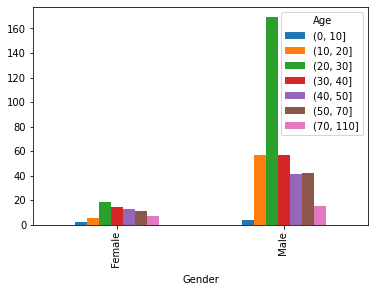

In [272]:
binned_cases.plot(kind="bar", legend=True)

<AxesSubplot:xlabel='Gender'>

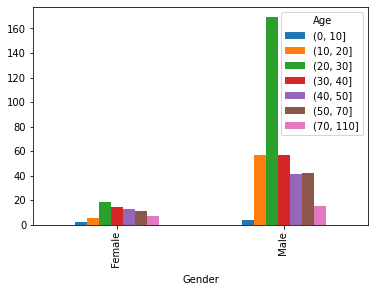

In [270]:
binned_cases.plot.bar(legend=True)

In [297]:
# add column with age bins
case_df['age_bin'] = pd.cut(case_df['Age'], bins=ages)

In [319]:
age_bin = pd.cut(case_df['Age'], bins=ages)

In [329]:
binned = pd.crosstab(age_bin,case_df['Gender'])
binned

Gender,Female,Male
Age,,
"(0, 10]",2,4
"(10, 20]",5,57
"(20, 30]",18,169
"(30, 40]",14,57
"(40, 50]",13,41
"(50, 70]",11,42
"(70, 110]",7,15


In [364]:
a = ['0-10', '11-20','21-30', '31-40', '41-50', '51-70', '+71']
binned['Age'] =a
binned.set_index('Age', inplace=True)
binned

Gender,Female,Male
Age,,
0-10,2,4
11-20,5,57
21-30,18,169
31-40,14,57
41-50,13,41
51-70,11,42
+71,7,15


In [366]:
binned.index

Index(['0-10', '11-20', '21-30', '31-40', '41-50', '51-70', '+71'], dtype='object', name='Age')

In [382]:
age_bar = plotting.figure(x_range=a, title='Victim Age Distribution', tools="wheel_zoom,reset,pan")
colors = ['royalblue', 'lightpink']
# each category needs an x axis range
age_bar.vbar_stack([' Male', ' Female'], x=['Age', 'Age'], width=0.9, source=binned, color=colors)
show(age_bar)

In [399]:
binned[' Male'].sum() / (binned[' Male'].sum() + binned[' Female'].sum())

0.8461538461538461

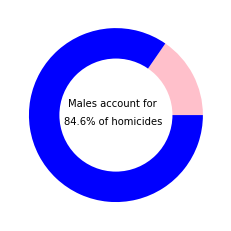

In [414]:
plt.pie([binned[' Female'].sum(), binned[' Male'].sum()], colors=['pink', 'blue'], #labels=['Female', 'Male'],
       pctdistance=0.2)
donut = plt.Circle((0,0), 0.65, fc='white')
plt.annotate('Males account for', (-0.55,0.1))
plt.annotate('84.6% of homicides', (-0.6,-0.1))
fig = plt.gcf()
fig.gca().add_artist(donut)
plt.show()